In [1]:
import tkinter as tk
from tkinter import ttk, messagebox
from tkinter import StringVar
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
import pandas as pd
from tkcalendar import DateEntry
import datetime
import geopandas as gpd
from scipy.interpolate import griddata, Rbf
import numpy as np
import mplcursors
import matplotlib.dates as mdates



ImportError: DLL load failed while importing _multiarray_umath: The specified module could not be found.

ImportError: DLL load failed while importing _multiarray_umath: The specified module could not be found.

In [33]:
from shapely import wkt
from shapely.geometry import Point
from matplotlib.figure import Figure
from geopandas import GeoSeries


combined_gdf = pd.read_csv("data/sensors_chp.csv")
combined_gdf['geometry'] = combined_gdf['geometry'].apply(wkt.loads)
combined_gdf = gpd.GeoDataFrame(combined_gdf, geometry='geometry')
combined_gdf.set_crs('EPSG:4326', inplace=True)

almaty_boundaries = gpd.read_file('notebook/almaty-districts.geo.json')
joined_gdf = gpd.sjoin(combined_gdf, almaty_boundaries, how='inner', predicate='intersects')
district_pollution = joined_gdf.groupby('name_right')['Reading'].mean().reset_index()
# almaty_boundaries['avg_pollution'] = almaty_boundaries['name'].map(
#             district_pollution.set_index('name_right')['Reading']
#         )
# almaty_boundaries
almaty_boundaries = almaty_boundaries.set_index('name')
district_pollution = district_pollution.set_index('name_right')
almaty_boundaries = almaty_boundaries.join(district_pollution)
almaty_boundaries.rename(columns={'Reading': 'avg_pm25'}, inplace=True)
almaty_boundaries.reset_index(inplace=True)
almaty_boundaries


,name,osm-relation-id,nameRu,geometry,avg_pm25
0,Turksib,3072001,Турксибский район,"MULTIPOLYGON (((76.93013 43.30047, 76.93018 43...",19.167571
1,Zhetysu,3072130,Жетысуский район,"MULTIPOLYGON (((76.88601 43.26865, 76.88577 43...",2.682374
2,Alatau,3072216,Алатауский район,"MULTIPOLYGON (((76.78266 43.31990, 76.77349 43...",18.991158
3,Medeu,3072217,Медеуский район,"MULTIPOLYGON (((76.92481 43.21553, 76.92488 43...",16.444091
4,Almaly,3072807,Алмалинский район,"MULTIPOLYGON (((76.86416 43.24793, 76.86428 43...",21.925122
5,Auezov,3072808,Ауэзовский район,"MULTIPOLYGON (((76.80955 43.23805, 76.80983 43...",16.487160
6,Bostandyq,3390291,Бостандыкский район,"MULTIPOLYGON (((76.86447 43.19540, 76.86402 43...",12.756895
7,Nauryzbay,5460063,Наурызбайский район,"MULTIPOLYGON (((76.78589 43.23229, 76.76946 43...",0.170959


In [25]:
almaty_boundaries = almaty_boundaries.join(district_pollution.set_index('name_right'))
almaty_boundaries

,osm-relation-id,name,nameRu,geometry,Reading
0,3072001,Turksib,Турксибский район,"MULTIPOLYGON (((76.93013 43.30047, 76.93018 43...",NaN
1,3072130,Zhetysu,Жетысуский район,"MULTIPOLYGON (((76.88601 43.26865, 76.88577 43...",NaN
2,3072216,Alatau,Алатауский район,"MULTIPOLYGON (((76.78266 43.31990, 76.77349 43...",NaN
3,3072217,Medeu,Медеуский район,"MULTIPOLYGON (((76.92481 43.21553, 76.92488 43...",NaN
4,3072807,Almaly,Алмалинский район,"MULTIPOLYGON (((76.86416 43.24793, 76.86428 43...",NaN
5,3072808,Auezov,Ауэзовский район,"MULTIPOLYGON (((76.80955 43.23805, 76.80983 43...",NaN
6,3390291,Bostandyq,Бостандыкский район,"MULTIPOLYGON (((76.86447 43.19540, 76.86402 43...",NaN
7,5460063,Nauryzbay,Наурызбайский район,"MULTIPOLYGON (((76.78589 43.23229, 76.76946 43...",NaN


In [7]:
class DataManipulator:
    def __init__(self, gdf, almaty_boundaries):
        self.gdf = gdf
        self.almaty_boundaries = almaty_boundaries

        power_plant_locations = [
            {'location': 'Power Plant 2', 'geometry': Point(77.0061645, 43.4224249)},
            {'location': 'Power Plant 3', 'geometry': Point(76.9278271, 43.280907)}
        ]

        self.power_plants_gdf = gpd.GeoDataFrame(power_plant_locations, crs=gdf.crs)

    
    def filter_data(self, start_date, end_date):
        start_date_str = start_date.strftime('%Y-%m-%d')
        end_date_str = end_date.strftime('%Y-%m-%d')

        filtered_gdf = combined_gdf[(combined_gdf['date'] >= start_date_str) & (combined_gdf['date'] <= end_date_str)]
        filtered_gdf = gpd.GeoDataFrame(filtered_gdf, geometry=filtered_gdf['geometry'], crs="EPSG:4326")
        filtered_gdf = filtered_gdf.to_crs(self.almaty_boundaries.crs)
        return filtered_gdf
        

    def get_statistics(self, gdf):

        if 'Reading' not in gdf.columns or gdf['Reading'].isnull().all():
            return None, None, None, None
        
        min = gdf['Reading'].min()
        max = gdf['Reading'].max()
        avg = gdf['Reading'].mean()
        var = gdf['Reading'].var()

        joined_gdf = gpd.sjoin(gdf, self.almaty_boundaries, how='inner', predicate='intersects')
        district_avg = joined_gdf.groupby('name_left')['Reading'].mean()

        most_polluted_district = district_avg.idxmax() if not district_avg.empty else None

        return min, max, avg, var, most_polluted_district
    

    def get_power_plant_data(self):
        return self.power_plants_gdf
    
    
    def calculate_pollution_by_district(self, gdf):
        # Perform a spatial join to map sensor readings to districts
        joined_gdf = gpd.sjoin(gdf, self.almaty_boundaries, how='inner', predicate='intersects')

        # Aggregate the average pollution for each district
        district_pollution = joined_gdf.groupby('name_right')['Reading'].mean().reset_index()
        # Now district_pollution has 'name_right' and 'Reading'

        self.almaty_boundaries['avg_pollution'] = self.almaty_boundaries['name'].map(
            district_pollution.set_index('name_right')['Reading']
        )
        
        return self.almaty_boundaries
    

    def interpolate(self, gdf, method='No Interpolation', grid_spacing=0.005):
        sensor_points = gdf[['geometry', 'Reading']].dropna(subset=['Reading'])

        if sensor_points.empty:
            tk.messagebox.showwarning("No Data", "No sensor data available for the selected date.")
            return

        lons = sensor_points.geometry.x.values
        lats = sensor_points.geometry.y.values
        readings = sensor_points['Reading'].values

        min_lon, min_lat, max_lon, max_lat = almaty_boundaries.total_bounds
        grid_spacing = 0.005  # Adjust this for desired resolution
        grid_lon = np.arange(min_lon, max_lon, grid_spacing)
        grid_lat = np.arange(min_lat, max_lat, grid_spacing)
        grid_lon, grid_lat = np.meshgrid(grid_lon, grid_lat)

        # Choose interpolation method
        if method == 'Nearest neighbor':
            # Nearest neighbor interpolation using griddata
            grid_z = griddata(
                points=(lons, lats),
                values=readings,
                xi=(grid_lon, grid_lat),
                method='nearest'
            )
        elif method == 'RBF':
            # RBF interpolation
            rbf_interpolator = Rbf(lons, lats, readings, function='multiquadric', smooth=0)
            grid_z = rbf_interpolator(grid_lon, grid_lat)
            grid_z = np.clip(grid_z, 0, 2)
        else:
            # Show the data without any interpolation
            grid_z = np.full(grid_lon.shape, np.nan)

        # Mask out areas outside Almaty boundaries
        boundary_polygon = almaty_boundaries.unary_union

        # Create grid points as a GeoDataFrame
        grid_points = np.vstack((grid_lon.flatten(), grid_lat.flatten())).T
        grid_points_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(grid_points[:,0], grid_points[:,1]), crs=almaty_boundaries.crs)

        # Check which points are within the boundary polygon
        grid_points_gdf['inside'] = grid_points_gdf.within(boundary_polygon)

        # Create mask (True for points outside the boundary)
        mask = ~grid_points_gdf['inside'].values.reshape(grid_lon.shape)

        # Apply mask to the interpolated grid
        grid_z_masked = np.ma.array(grid_z, mask=mask)

        return grid_z_masked, grid_lon, grid_lat

almaty_boundaries = gpd.read_file('notebook/almaty-districts.geo.json')
dataManipulator = DataManipulator(combined_gdf, almaty_boundaries)


c:\Users\Dias\miniconda3\envs\proj_phys4038\Lib\site-packages\mplcursors\_pick_info.py:142: UserWarning: Pick support for QuadMesh is missing.
  warnings.warn(f"Pick support for {type(artist).__name__} is missing.")
c:\Users\Dias\miniconda3\envs\proj_phys4038\Lib\site-packages\mplcursors\_pick_info.py:142: UserWarning: Pick support for QuadMesh is missing.
  warnings.warn(f"Pick support for {type(artist).__name__} is missing.")


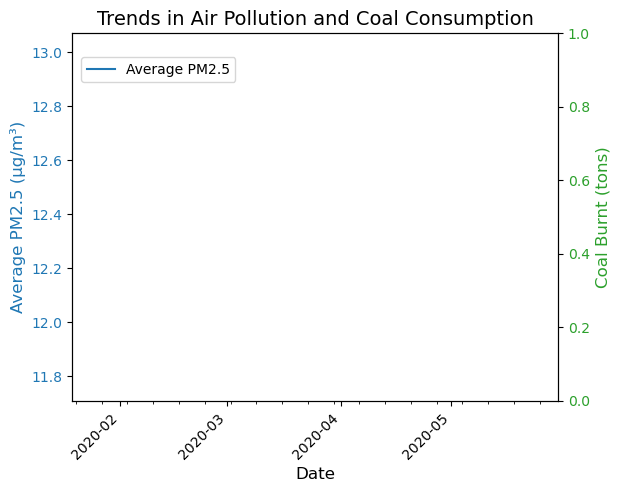

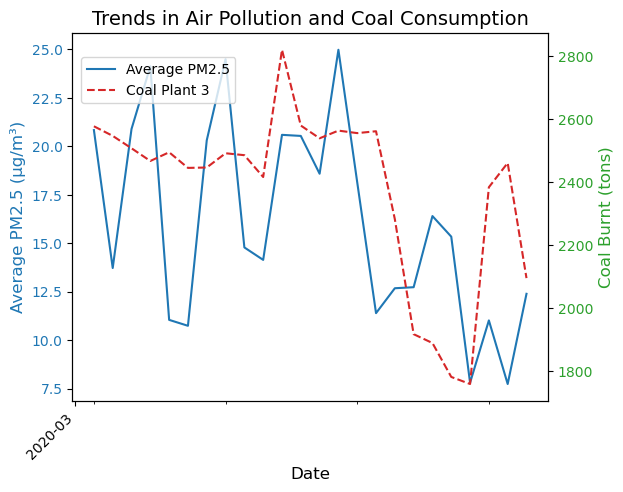

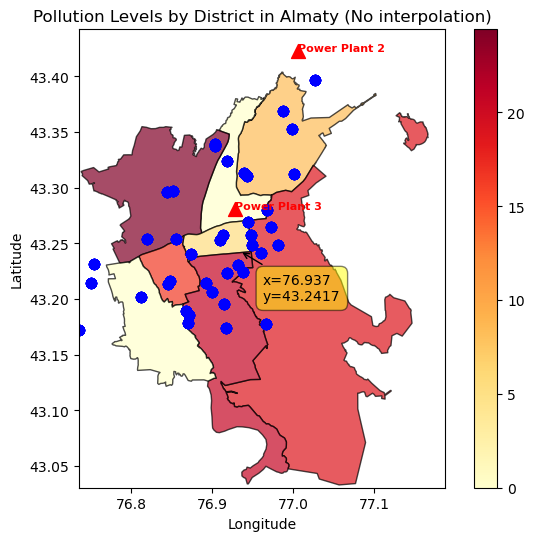

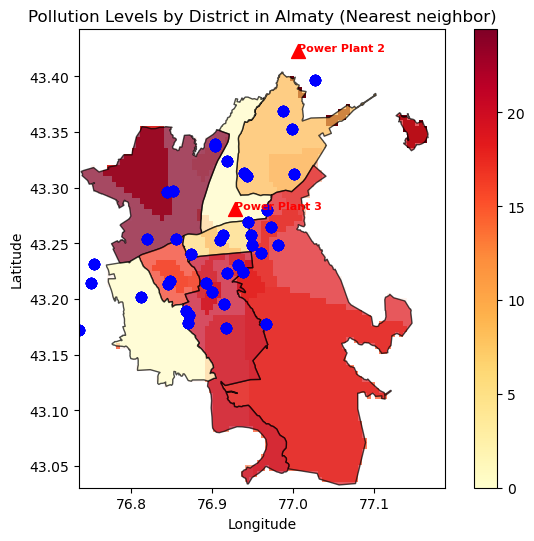

In [4]:
class AQApp(tk.Tk):
    def __init__(self):
        super().__init__()
        self.title("Almaty AirQ")   
        self.geometry("800x600")

        self.app_settings = {
            "theme": "Light",
            "font": "Arial",
            "font_size": 12
        }

        menubar = tk.Menu(self) 

        file_menu = tk.Menu(menubar, tearoff=0)
        menubar.add_cascade(label='File', menu=file_menu)
        file_menu.add_command(label='<< To menu', command=lambda: self.show_frame("HomePage"))
        file_menu.add_command(label='Open...', command=None)
        file_menu.add_separator()
        file_menu.add_command(label='Exit', command=self.exit_app)

        help_menu = tk.Menu(menubar, tearoff=0)
        help_menu.add_command(label='About', command=self.show_about)
        menubar.add_cascade(label='Help', menu=help_menu)

        self.grid_rowconfigure(0, weight=1)
        self.grid_columnconfigure(0, weight=1)

        self.frames = {}
        for F in (HomePage, VizPage, CorrPage, SettingsPage, AboutPage):
            page_n = F.__name__
            frame = F(parent=self, controller=self)
            self.frames[page_n] = frame
            frame.grid(row=0, column=0, sticky="nsew") 

        self.show_frame("HomePage")

        self.config(menu=menubar)

    def show_frame(self, pagename):
        frame = self.frames[pagename]
        frame.tkraise()

    def apply_settings(self):
        settings = self.app_settings
        theme_colors = {
            "Light": {"bg": "white", "fg": "black"},
            "Dark": {"bg": "black", "fg": "white"},
        }
        theme = theme_colors.get(settings["theme"], theme_colors["Light"])

        for frame in self.frames.values():
            frame.configure(bg=theme["bg"])
            for widget in frame.winfo_children():
                if isinstance(widget, tk.Label) or isinstance(widget, tk.Button):
                    widget.configure(
                        font=(settings["font"], settings["font_size"]),
                        bg=theme["bg"],
                        fg=theme["fg"]
                    )


    def exit_app(self):
        self.destroy()

    def show_about(self):
        """Show About dialog"""
        tk.messagebox.showinfo("About", "Almaty AirQ Application\nVersion 0.01\nDeveloped as a Project Work for Scientific Programming in Python Course @ University of Nottingham")


class HomePage(tk.Frame):
    def __init__(self, parent, controller):
        super().__init__(parent) 
        self.controller = controller

        self.grid_rowconfigure(0, weight=1)  
        self.grid_rowconfigure(1, weight=0)  
        self.grid_rowconfigure(2, weight=0)  
        self.grid_rowconfigure(3, weight=0)  
        self.grid_rowconfigure(4, weight=0)  
        self.grid_rowconfigure(5, weight=0) 
        self.grid_rowconfigure(6, weight=1) 

        self.grid_columnconfigure(0, weight=1) 
        self.grid_columnconfigure(1, weight=0) 
        self.grid_columnconfigure(2, weight=1)

        self.configure(bg="#e0f7fa")

        # bg_image = tk.PhotoImage(file="bg_main.png")
        # bg_label = tk.Label(self, image=bg_image)
        # bg_label.place(relwidth=1, relheight=1)
        # bg_label.image = bg_image

        button_width = 20

        def on_enter(e):
            e.widget['bg'] = '#004d40' 
            e.widget['font'] = ("Helvetica", 10, "bold")

        def on_leave(e):
            e.widget['bg'] = 'grey' 
            e.widget['font'] = ("Helvetica", 10)

        label = tk.Label(self, text="AirQ Almaty", font=("Helvetica", 24), fg="#004d40", bg="#e0f7fa")
        label.grid(row=1, column=1, sticky="", padx=0, pady=0)

        vz_page_button = tk.Button(self, text="Data Visualization", font=("Helvetica", 10), width=button_width, bg='grey', command=lambda: controller.show_frame("VizPage"))
        vz_page_button.grid(row=2, column=1, sticky="", padx=20, pady=10)
        vz_page_button.bind("<Enter>", on_enter)
        vz_page_button.bind("<Leave>", on_leave)

        corr_page_button = tk.Button(self, text="Correlation Analysis", font=("Helvetica", 10), width=button_width, bg='grey', command=lambda: controller.show_frame("CorrPage"))
        corr_page_button.grid(row=3, column=1, sticky="", padx=20, pady=10)
        corr_page_button.bind("<Enter>", on_enter)
        corr_page_button.bind("<Leave>", on_leave)

        sttgs_page_button = tk.Button(self, text="Settings", font=("Helvetica", 10), width=button_width, bg='grey', command=lambda: controller.show_frame("SettingsPage"))
        sttgs_page_button.grid(row=4, column=1, sticky="", padx=20, pady=10)
        sttgs_page_button.bind("<Enter>", on_enter)
        sttgs_page_button.bind("<Leave>", on_leave)

        about_page_button = tk.Button(self, text="About", font=("Helvetica", 10), width=button_width, bg='grey', command=lambda: controller.show_frame("AboutPage"))
        about_page_button.grid(row=5, column=1, sticky="", padx=20, pady=10)
        about_page_button.bind("<Enter>", on_enter)
        about_page_button.bind("<Leave>", on_leave)



class VizPage(tk.Frame):
    def __init__(self, parent, controller):
        super().__init__(parent)
        self.controller = controller
        self.data_manipulator = dataManipulator
        
        self.grid_columnconfigure(0, weight=0)  
        self.grid_columnconfigure(1, weight=1)  
        self.grid_rowconfigure(0, weight=0)  
        self.grid_rowconfigure(1, weight=1)  

        self.create_widgets()

    def create_widgets(self):
        top_frame = tk.Frame(self, bg='#f0f0f0')
        top_frame.grid(row=0, column=0, columnspan=2, sticky='ew', pady=10)

        date_label = tk.Label(top_frame, text="Select Date:", bg='#f0f0f0', font=("Arial", 12))
        date_label.pack(side='left', padx=10, pady=5)

        self.date_var = tk.StringVar()
        date_entry = DateEntry(
            top_frame,
            textvariable=self.date_var,
            date_pattern='yyyy-mm-dd', 
            showweeknumbers=False,      
            maxdate=datetime.date(2020, 3, 25),               
            mindate=datetime.date(2019, 1, 1),  
            font=("Helvetica", 12)          
        )
        date_entry.pack(side='left', padx=10, pady=5)

        self.date_var2 = tk.StringVar()
        date_entry2 = DateEntry(
            top_frame,
            textvariable=self.date_var2,
            date_pattern='yyyy-mm-dd', 
            showweeknumbers=False,      
            maxdate=datetime.date(2020, 3, 25),               
            mindate=datetime.date(2019, 1, 1),  
            font=("Helvetica", 12)          
        )
        date_entry2.pack(side='left', padx=10, pady=5)

        #dropdown menu
        selected_option = StringVar()
        selected_option.set("No Interpolation")

        options = [ 
            "No Interpolation", 
            "Nearest neighbor", 
            "RBF", 
        ] 

        dropdown = tk.OptionMenu(top_frame, selected_option, *options)
        dropdown.pack(side='left', padx=10, pady=5)

        update_button = tk.Button(
            top_frame, 
            text="Update Map", 
            command=lambda: self.update_summary(interpolation=selected_option.get())
        )
        update_button.pack(side='left', padx=10, pady=5)

        

        sidebar = tk.Frame(self, width=200, bg='#f0f0f0')
        sidebar.grid(row=1, column=0, sticky='ns', pady=10)

        title_label = tk.Label(sidebar, text="Data Visualization", font=("Helvetica", 16), bg='#f0f0f0')
        title_label.pack(anchor='nw', pady=10)

        summary_label = tk.Label(sidebar, text="Summary Statistics", font=("Helvetica", 12), bg='#f0f0f0')
        summary_label.pack(anchor='nw')

        self.stats_label = tk.Label(sidebar, text="", font=("Helvetica", 10), bg='#f0f0f0', justify="left")
        self.stats_label.pack(anchor='nw')

        self.map_frame = tk.Frame(self, bg='white')
        self.map_frame.grid(row=1, column=1, sticky='nsew', pady=10)

    def update_summary(self, interpolation='No Interpolation'):
        selected_date = pd.to_datetime(self.date_var.get())
        selected_date2 = pd.to_datetime(self.date_var2.get())
        filtered_gdf = self.data_manipulator.filter_data(start_date=selected_date, end_date=selected_date2)

        # Calculate districts pollution before plotting
        self.districts_gdf = self.data_manipulator.calculate_pollution_by_district(filtered_gdf)

        self.plot_map(gdf=filtered_gdf, method=interpolation)

        # Get statistics
        min_val, max_val, avg_val, var_val, most_polluted_district = self.data_manipulator.get_statistics(filtered_gdf)


        # Prepare formatted strings
        avg_text = f"{avg_val:.2f}" if avg_val is not None else "NaN"
        var_text = f"{var_val:.2f}" if var_val is not None else "NaN"
        min_text = f"{min_val:.2f}" if min_val is not None else "NaN"
        max_text = f"{max_val:.2f}" if max_val is not None else "NaN"
        district_text = most_polluted_district if most_polluted_district else "No data"

        # Update stats label text
        stats_text = (
            f"Average PM2.5: {avg_text}\n"
            f"Variance: {var_text}\n"
            f"Minimum: {min_text}\n"
            f"Maximum: {max_text}\n"
            f"Most Polluted District: {district_text}"
        )
        self.stats_label.config(text=stats_text)


    def plot_map(self, gdf, method='No Interpolation'):
        # Interpolation (if applicable)
        grid_z_masked, grid_lon, grid_lat = self.data_manipulator.interpolate(gdf=gdf, method=method)

        # Plotting
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))

        # Plot interpolated data (if needed behind the districts)
        cmap = plt.get_cmap('Reds')
        interpolation_plot = ax.pcolormesh(grid_lon, grid_lat, grid_z_masked, cmap=cmap, shading='auto')

        # Plot districts color-coded by their average pollution
        if hasattr(self, 'districts_gdf'):
            district_plot = self.districts_gdf.plot(
                ax=ax,
                column='avg_pollution',  # Use average pollution for coloring
                cmap='YlOrRd',
                legend=True,
                edgecolor='black',
                alpha=0.7
            )

        # Add sensor locations
        gdf.plot(ax=ax, color='blue', markersize=50, marker='o', label='Sensors')

        # Add power plant locations
        power_plants_gdf = self.data_manipulator.get_power_plant_data()
        power_plants_gdf.plot(ax=ax, color='red', markersize=100, marker='^', label='Power Plants')

        # Add labels to power plants
        for idx, row in power_plants_gdf.iterrows():
            ax.text(
                row.geometry.x, row.geometry.y,
                row['location'],
                fontsize=8, color='red', weight='bold'
            )

        # Add hover tooltips for districts
        cursor = mplcursors.cursor(district_plot.collections, hover=True)
        @cursor.connect("add")
        def on_add(sel):
            if hasattr(sel.artist, "column") and sel.artist.column == "avg_pollution":
                district_name = self.districts_gdf.iloc[sel.index]["name"]
                pollution_level = self.districts_gdf.iloc[sel.index]["avg_pollution"]
                sel.annotation.set_text(f"{district_name}\nAvg PM2.5: {pollution_level:.2f}")

        # Final map styling
        plt.title(f"Pollution Levels by District in Almaty ({method.capitalize()})")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.tight_layout()

        # Update the Tkinter canvas
        for widget in self.map_frame.winfo_children():
            widget.destroy()

        canvas = FigureCanvasTkAgg(fig, master=self.map_frame)
        canvas.draw()
        canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)





class CorrPage(tk.Frame):
    def __init__(self, parent, controller):
        super().__init__(parent)
        self.controller = controller
        self.data_manipulator = dataManipulator

        self.grid_columnconfigure(0, weight=0)  
        self.grid_columnconfigure(1, weight=1)  
        self.grid_rowconfigure(0, weight=0)  
        self.grid_rowconfigure(1, weight=1)  

        self.create_widgets()

    def create_widgets(self):
        top_frame = tk.Frame(self, bg='#f0f0f0')
        top_frame.grid(row=0, column=0, columnspan=2, sticky='ew', pady=10)

        date_label = tk.Label(top_frame, text="Select Date:", bg='#f0f0f0', font=("Arial", 12))
        date_label.pack(side='left', padx=10, pady=5)

        self.date_var = tk.StringVar()
        date_entry = DateEntry(
            top_frame,
            textvariable=self.date_var,
            date_pattern='yyyy-mm-dd', 
            showweeknumbers=False,      
            maxdate=datetime.date(2020, 3, 25),               
            mindate=datetime.date(2019, 1, 1),  
            font=("Helvetica", 12)          
        )
        date_entry.pack(side='left', padx=10, pady=5)

        self.date_var2 = tk.StringVar()
        date_entry2 = DateEntry(
            top_frame,
            textvariable=self.date_var2,
            date_pattern='yyyy-mm-dd', 
            showweeknumbers=False,      
            maxdate=datetime.date(2020, 3, 25),               
            mindate=datetime.date(2019, 1, 1),  
            font=("Helvetica", 12)          
        )
        date_entry2.pack(side='left', padx=10, pady=5)

        self.isShowCP2 = tk.IntVar()
        self.isShowCP3 = tk.IntVar()

        checkbox1 = tk.Checkbutton(top_frame, text="Show Coal Plant 2", variable=self.isShowCP2)
        checkbox1.pack()

        checkbox2 = tk.Checkbutton(top_frame, text="Show Coal Plant 2", variable=self.isShowCP3)
        checkbox2.pack()

        update_button = tk.Button(
            top_frame, 
            text="Update Plot", 
            command=lambda: self.update_summary()
        )
        update_button.pack(side='left', padx=10, pady=5)

        sidebar = tk.Frame(self, width=200, bg='#f0f0f0')
        sidebar.grid(row=1, column=0, sticky='ns', pady=10)

        summary_label = tk.Label(sidebar, text="Summary Statistics", font=("Helvetica", 12), bg='#f0f0f0')
        summary_label.pack(anchor='nw')

        self.stats_label = tk.Label(sidebar, text="", font=("Helvetica", 10), bg='#f0f0f0', justify="left")
        self.stats_label.pack(anchor='nw')

        self.map_frame = tk.Frame(self, bg='white')
        self.map_frame.grid(row=1, column=1, sticky='nsew', pady=10)


    def update_summary(self):
        selected_date = pd.to_datetime(self.date_var.get())
        selected_date2 = pd.to_datetime(self.date_var2.get())
        filtered_gdf = self.data_manipulator.filter_data(start_date=selected_date, end_date=selected_date2)

        # Calculate districts pollution before plotting
        self.districts_gdf = self.data_manipulator.calculate_pollution_by_district(filtered_gdf)

        # Get statistics
        min_val, max_val, avg_val, var_val, most_polluted_district = self.data_manipulator.get_statistics(filtered_gdf)


        # Prepare formatted strings
        avg_text = f"{avg_val:.2f}" if avg_val is not None else "NaN"
        var_text = f"{var_val:.2f}" if var_val is not None else "NaN"
        min_text = f"{min_val:.2f}" if min_val is not None else "NaN"
        max_text = f"{max_val:.2f}" if max_val is not None else "NaN"
        district_text = most_polluted_district if most_polluted_district else "No data"

        # Update stats label text
        stats_text = (
            f"Average PM2.5: {avg_text}\n"
            f"Variance: {var_text}\n"
            f"Minimum: {min_text}\n"
            f"Maximum: {max_text}\n"
            f"Most Polluted District: {district_text}"
        )
        self.stats_label.config(text=stats_text)

        self.plot_frame(filtered_gdf, show_cp2=self.isShowCP2.get(), show_cp3=self.isShowCP3.get())

    def plot_frame(self, filtered_gdf, show_cp2, show_cp3):
        # Clear the existing plot in map_frame
        for widget in self.map_frame.winfo_children():
            widget.destroy()

        # Prepare the data for plotting
        # Group by date and calculate average PM2.5
        daily_avg = filtered_gdf.groupby('date')['Reading'].mean().reset_index()

        # Extract coal consumption data
        daily_cp2 = filtered_gdf.groupby('date')['ТЭЦ2, тонн'].mean().reset_index()
        daily_cp3 = filtered_gdf.groupby('date')['ТЭЦ3, тонн'].mean().reset_index()

        # Convert dates to datetime if not already
        daily_avg['date'] = pd.to_datetime(daily_avg['date'])
        daily_cp2['date'] = pd.to_datetime(daily_cp2['date'])
        daily_cp3['date'] = pd.to_datetime(daily_cp3['date'])

        # Create a new Matplotlib figure
        fig, ax1 = plt.subplots(figsize=(8, 6))

        # Plot average PM2.5
        ax1.set_xlabel('Date', fontsize=12)
        ax1.set_ylabel('Average PM2.5 (µg/m³)', color='tab:blue', fontsize=12)

        # Set up date ticks
        ax1.xaxis.set_major_locator(mdates.MonthLocator())
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax1.xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=mdates.MO))

        # Plot PM2.5 readings
        ax1.plot(daily_avg['date'], daily_avg['Reading'], label='Average PM2.5', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')

        # Rotate x-axis tick labels
        plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

        # Create a secondary y-axis for coal consumption
        ax2 = ax1.twinx()
        ax2.set_ylabel('Coal Burnt (tons)', color='tab:green', fontsize=12)

        # Plot coal consumption if toggled
        if show_cp2:
            ax2.plot(daily_cp2['date'], daily_cp2['ТЭЦ2, тонн'], label='Coal Plant 2', color='tab:green', linestyle='--')
        if show_cp3:
            ax2.plot(daily_cp3['date'], daily_cp3['ТЭЦ3, тонн'], label='Coal Plant 3', color='tab:red', linestyle='--')

        ax2.tick_params(axis='y', labelcolor='tab:green')

        # Add legends and title
        fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
        ax1.set_title('Trends in Air Pollution and Coal Consumption', fontsize=14)

        # Adjust layout to prevent cutting off labels
        fig.tight_layout()

        # Convert Matplotlib figure to Tkinter canvas
        canvas = FigureCanvasTkAgg(fig, master=self.map_frame)
        canvas.draw()
        canvas.get_tk_widget().pack(fill='both', expand=True)




        
        


class SettingsPage(tk.Frame):
    def __init__(self, parent, controller):
        super().__init__(parent)
        self.controller = controller

        tk.Label(self, text="Settings", font=("Arial", 18)).pack(pady=10)

        # Theme Settings
        tk.Label(self, text="Select Theme:", font=("Arial", 12)).pack(anchor="w", padx=20)
        theme_var = tk.StringVar(value="Light")
        theme_dropdown = tk.OptionMenu(self, theme_var, "Light", "Dark")
        theme_dropdown.pack(anchor="w", padx=20)

        # Font Settings
        tk.Label(self, text="Select Font:", font=("Arial", 12)).pack(anchor="w", padx=20)
        font_var = tk.StringVar(value="Arial")
        font_dropdown = tk.OptionMenu(self, font_var, "Arial", "Helvetica", "Courier")
        font_dropdown.pack(anchor="w", padx=20)

        # Font Size Slider
        tk.Label(self, text="Font Size:", font=("Arial", 12)).pack(anchor="w", padx=20)
        font_size_var = tk.IntVar(value=12)  # Default size
        font_size_slider = tk.Scale(self, from_=8, to=24, orient="horizontal", variable=font_size_var)
        font_size_slider.pack(anchor="w", padx=20)

        # Save Button
        save_button = tk.Button(self, text="Save Settings", command=lambda: self.save_settings(theme_var.get(), font_var.get(), font_size_var.get()))
        save_button.pack(pady=20)

    def save_settings(self, theme, font, font_size):
        
        self.controller.app_settings["theme"] = theme
        self.controller.app_settings["font"] = font
        self.controller.app_settings["font_size"] = font_size

        self.controller.apply_settings()

        tk.messagebox.showinfo(
            "Settings Saved",
            f"Theme: {theme}\nFont: {font}\nFont Size: {font_size}",
        )


class AboutPage(tk.Frame):
    def __init__(self, parent, controller):
        super().__init__(parent)
        self.controller = controller

        self.plot_frame = tk.Frame(self)
        self.plot_frame.pack(fill="both", expand=True)




app = AQApp()

app.mainloop()